In [75]:
! pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
    Running setup.py install for fbprophet ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0r93nddz/fbprophet_e46a068baa674c1ab5e6f73e55b9812b/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0r93nddz/fbprophet_e46a068baa674c1ab5e6f73e55b9812b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-qedao26v/install-record.txt --single-version-externally-managed --compile --install-hea

In [109]:
# Data Pre-Processing packages:
import numpy as np 
import pandas as pd 
from datetime import datetime


# Data Visualization Packages:
# Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg


# Garbage collector - To free up unused space
import gc
gc.collect()

# NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

# To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Time series Analysis pacakages:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time to calculate long each cell takes to run
import time


In [110]:
#Importing of Data 
data=pd.read_csv('/content/drive/MyDrive/Berleley-Final-Project/Final-notebooks and data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [111]:
# Importing FB Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

##Data set Overview & Pre-Processing

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [113]:
data.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

# Data Pre-processing steps
1. <b>Date</b> - I am going to convert the Hourly data to daily frequency
2. I m going to fill-in the missing values by interpolation

</div>

The data is available on a Hourly based on each day, So I need to resample the column to day frequency.

In [114]:
data['Timestamp'] = [datetime.fromtimestamp(x) for x in data['Timestamp']]
data = data.set_index('Timestamp')
data = data.resample("24H").mean()
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


### Let's look for missing values

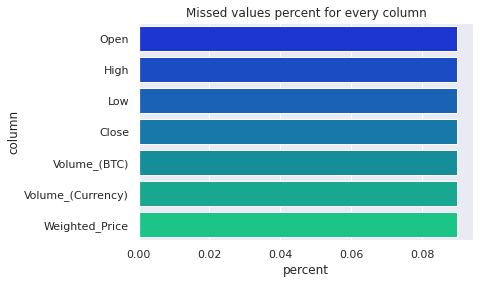

In [115]:
missed = pd.DataFrame()
missed['column'] = data.columns

missed['percent'] = [round(100* data[col].isnull().sum() / len(data), 2) for col in data.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]

fig = sns.barplot(
    x=missed['percent'], 
    y=missed["column"], 
    orientation='horizontal',palette="winter"
).set_title('Missed values percent for every column')

### I am going to fill the missing values by interpolating

In [117]:
def fill_missing(df):
    ### function to impute missing values using interpolation
    
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(data)

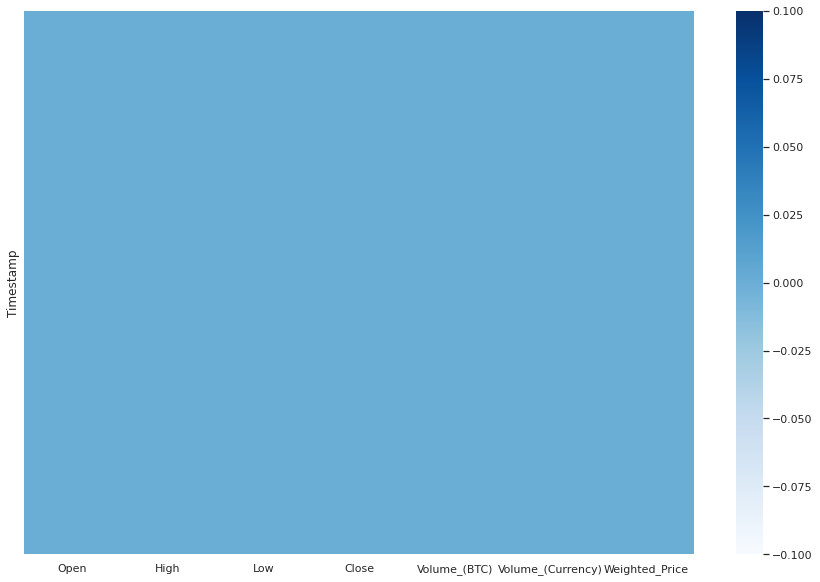

In [118]:
# Let's plot to see if there are any missing valuues
plt.figure(figsize=(15,10))
sns.heatmap(data.isna(),yticklabels=False,cbar=True, cmap='Blues')
plt.show()

## Features Engineering

In [119]:
new_df=data.groupby('Timestamp').mean()
new_df=new_df[['Volume_(BTC)', 'Close','Volume_(Currency)']]
new_df.rename(columns={'Volume_(BTC)':'Volume_market_mean','Close':'close_mean','Volume_(Currency)':'volume_curr_mean'},inplace=True)
new_df.head()

,Volume_market_mean,close_mean,volume_curr_mean
Timestamp,,,
2011-12-31,23.829470,4.482500,106.330084
2012-01-01,7.200667,4.806667,35.259720
2012-01-02,19.048000,5.000000,95.240000
2012-01-03,11.004660,5.252500,58.100651
2012-01-04,11.914807,5.223333,63.119577


In [120]:
data_df = data.merge(new_df, left_on='Timestamp',
                                right_index=True)
data_df['volume(BTC)/Volume_market_mean'] = data_df['Volume_(BTC)'] / data_df['Volume_market_mean']
data_df['Volume_(Currency)/volume_curr_mean'] = data_df['Volume_(Currency)'] / data_df['volume_curr_mean']

data_df['close/close_market_mean'] = data_df['Close'] / data_df['close_mean']
data_df['open/close'] = data_df['Open'] / data_df['Close']
data_df["gap"] = data_df["High"] - data_df["Low"] 
data_df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume_market_mean,close_mean,volume_curr_mean,volume(BTC)/Volume_market_mean,Volume_(Currency)/volume_curr_mean,close/close_market_mean,open/close,gap
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,23.829470,4.482500,106.330084,1.0,1.0,1.0,0.996096,0.017500
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,7.200667,4.806667,35.259720,1.0,1.0,1.0,1.000000,0.000000
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,19.048000,5.000000,95.240000,1.0,1.0,1.0,1.000000,0.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,11.004660,5.252500,58.100651,1.0,1.0,1.0,1.000000,0.000000
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,11.914807,5.223333,63.119577,1.0,1.0,1.0,0.995533,0.023333


<div class='alert alert-info'>
     <p> The dataset might be toobig to process, since I am using dataframe. To make sure I don't use too much RAM. I will try approaches like:</p>
     <p> 1. use gc.collect() - collects all the garbage values </p>
     <p> 2. del dataframe - free up some space by deleting the unused dataframe using the del command </p>
     <p> 3. Reduce the memory usage based on the data types of the columns in the dataframe(shown below)</p>
</div>
In order to ensure I don't use too much RAM. I will perform the follwoing steps:

1. use gc.collect() - collects all the garbage values

2. del dataframe - to free up some space by deleting the unused dataframe by using the del command

3. Reduce the memory usage based on the data types of the columns in the dataframe(shown below)

In [121]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
data_df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume_market_mean,close_mean,volume_curr_mean,volume(BTC)/Volume_market_mean,Volume_(Currency)/volume_curr_mean,close/close_market_mean,open/close,gap
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,23.829470,4.482500,106.330084,1.0,1.0,1.0,0.996096,0.017500
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,7.200667,4.806667,35.259720,1.0,1.0,1.0,1.000000,0.000000
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,19.048000,5.000000,95.240000,1.0,1.0,1.0,1.000000,0.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,11.004660,5.252500,58.100651,1.0,1.0,1.0,1.000000,0.000000
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,11.914807,5.223333,63.119577,1.0,1.0,1.0,0.995533,0.023333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260,1.823877,55195.415367,100884.732367,1.0,1.0,1.0,0.999961,50.907659
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824,1.447939,55835.012863,80632.115263,1.0,1.0,1.0,0.999975,47.310216
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819,3.732887,56915.629993,213754.555988,1.0,1.0,1.0,0.999987,60.970627


In [123]:
# All the columns in float64 format, I can downsize them to float32 to reduce memory usage 
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3379 entries, 2011-12-31 to 2021-03-31
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Open                                3379 non-null   float64
 1   High                                3379 non-null   float64
 2   Low                                 3379 non-null   float64
 3   Close                               3379 non-null   float64
 4   Volume_(BTC)                        3379 non-null   float64
 5   Volume_(Currency)                   3379 non-null   float64
 6   Weighted_Price                      3379 non-null   float64
 7   Volume_market_mean                  3379 non-null   float64
 8   close_mean                          3379 non-null   float64
 9   volume_curr_mean                    3379 non-null   float64
 10  volume(BTC)/Volume_market_mean      3379 non-null   float64
 11  Volume_(Currency)/volume_

I am going to use the function pd.to_numeric() to downcast the float types. I will use DataFrame.select_dtypes to select only the float columns, then optimize the types and compare the memory usage.

In [124]:
gl_float = data_df.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')
compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['Before','After']
compare_floats.apply(pd.Series.value_counts)

,Before,After
float32,NaN,15.0
float64,15.0,NaN


### Now I have successfully reduced the size of the dataframe by 50%. Eventhough, the size of the dataframe used here is small in this analysis. It is always a good aprroach to reduce the memory usage.

Let's Visualize the distribution of the key variables like Opening price, Highest price, Lowest price and Volume in Bitcoin

In [126]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

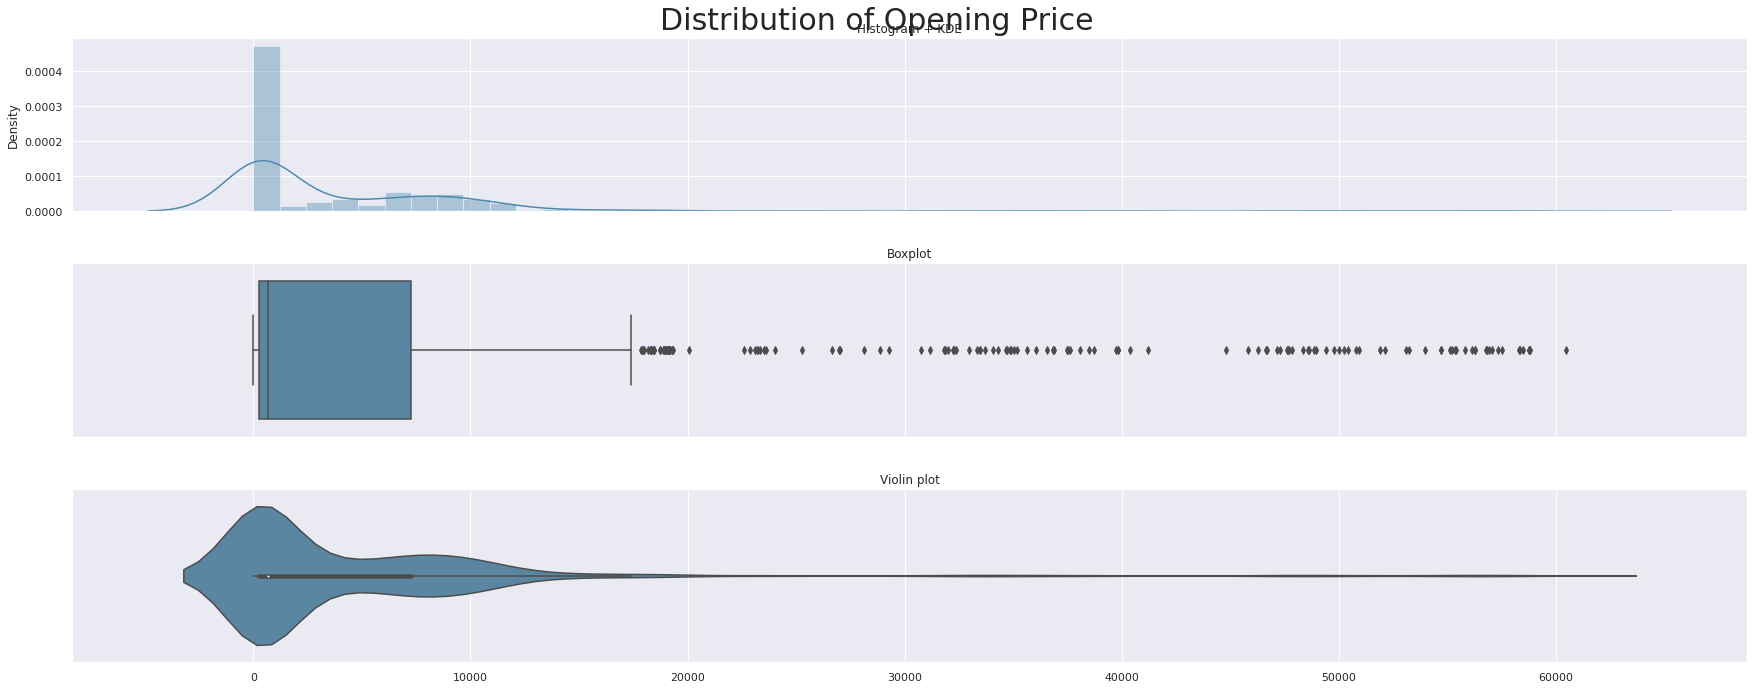

In [128]:
triple_plot(data['Open'],'Distribution of Opening Price', custom_colors[0])

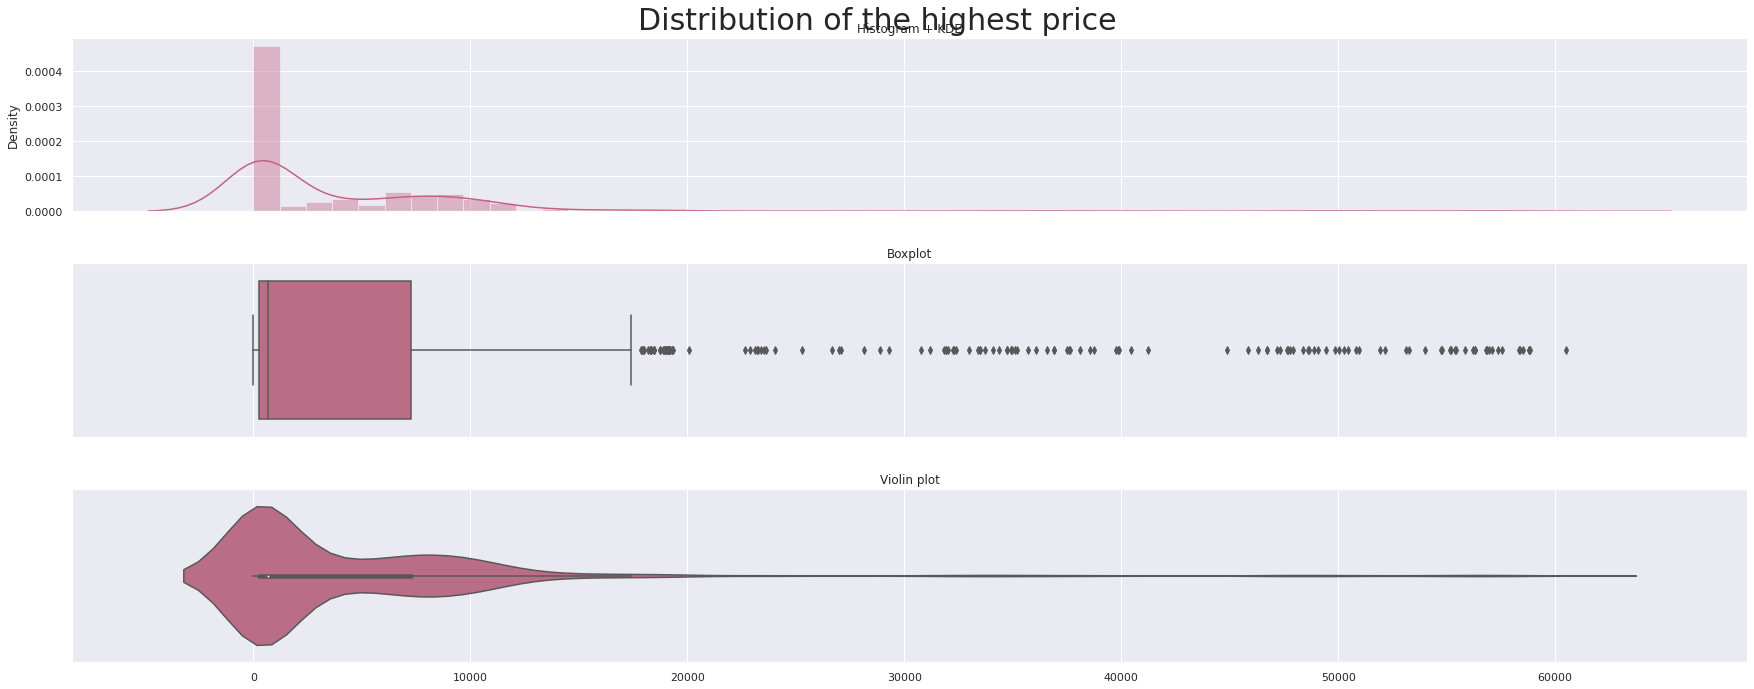

In [129]:
triple_plot(data['High'],'Distribution of the highest price', custom_colors[1])

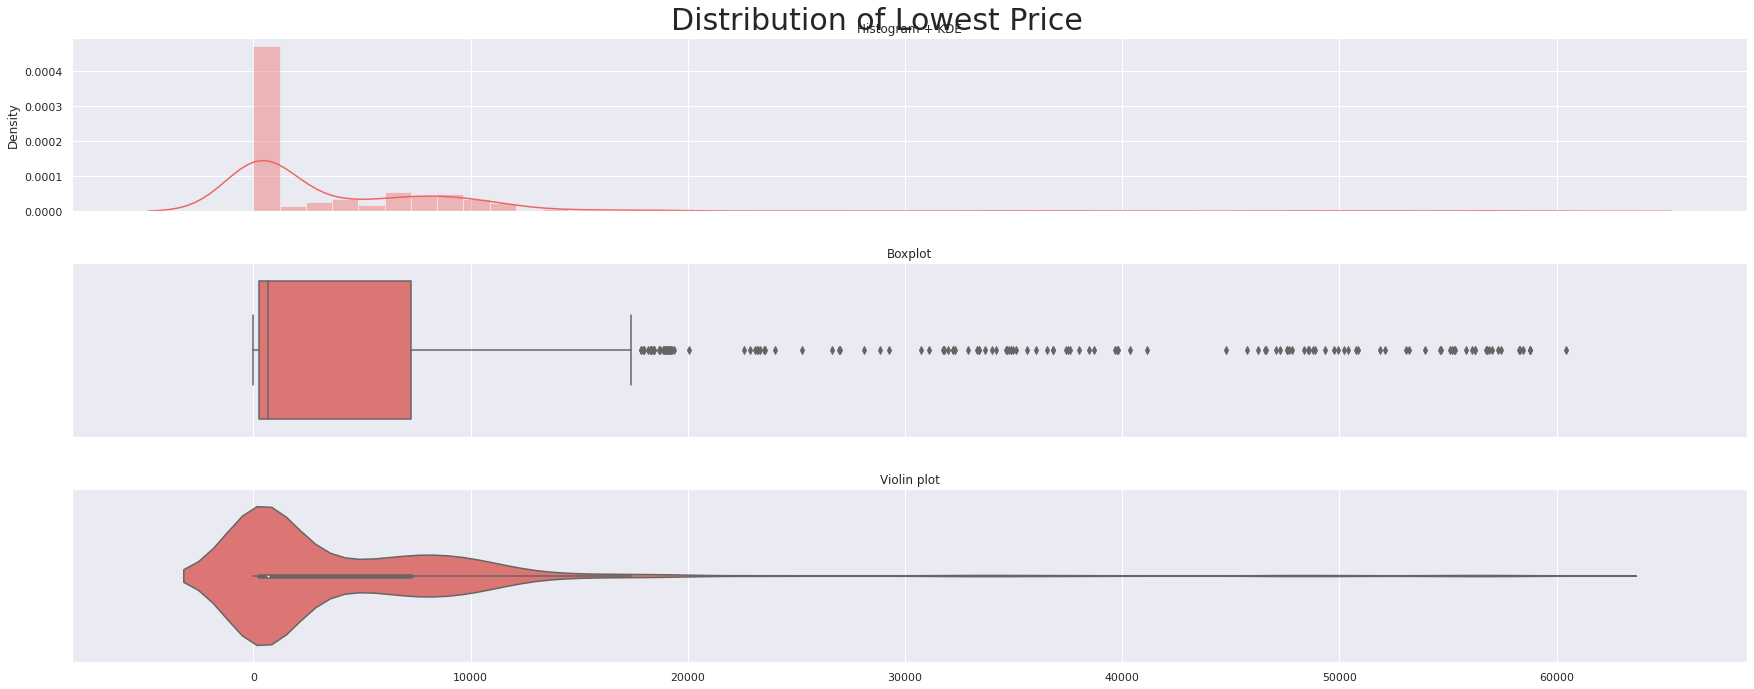

In [130]:
triple_plot(data['Low'],'Distribution of Lowest Price',custom_colors[2])

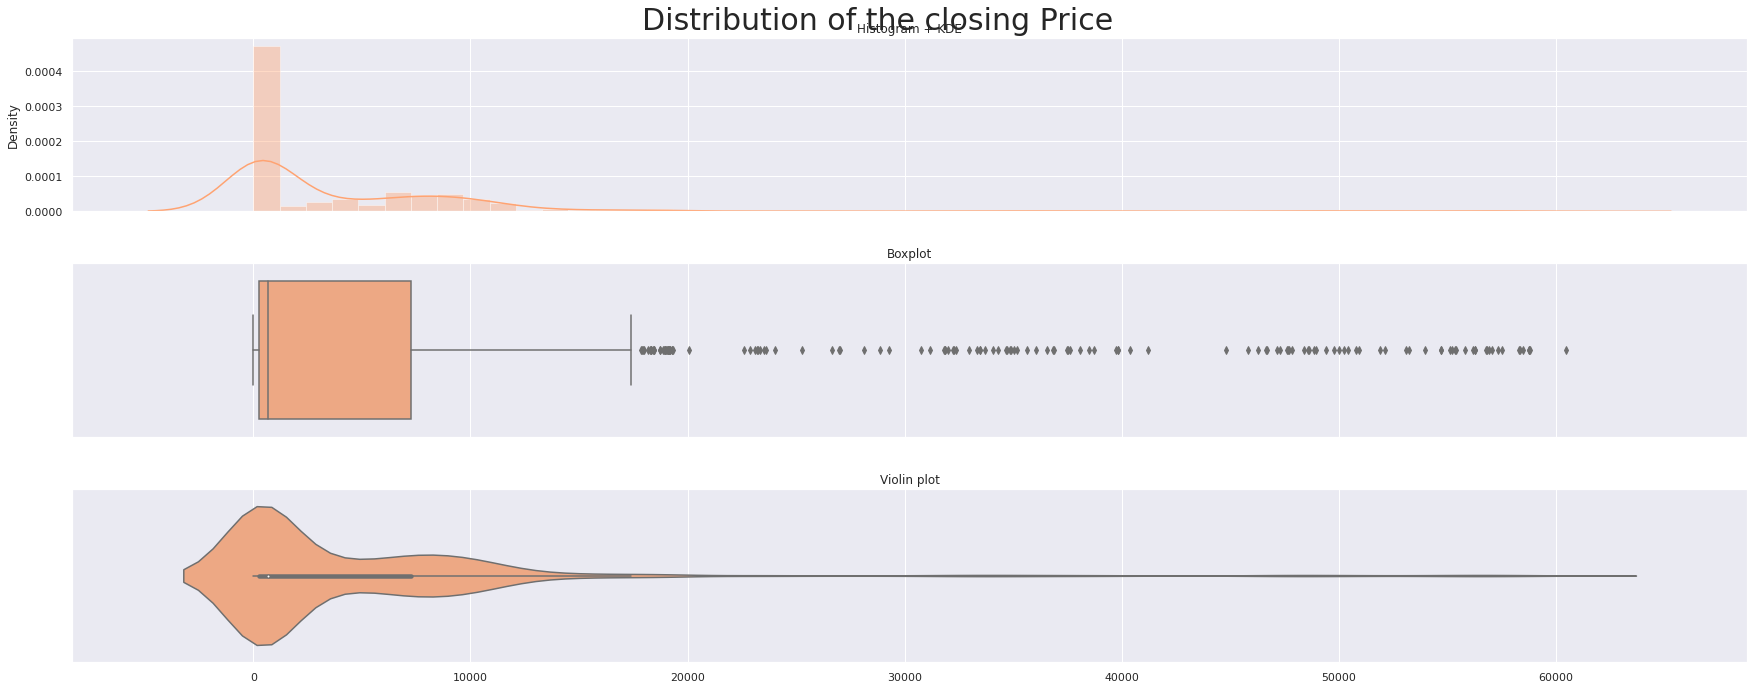

In [131]:
triple_plot(data['Close'],'Distribution of the closing Price',custom_colors[3])

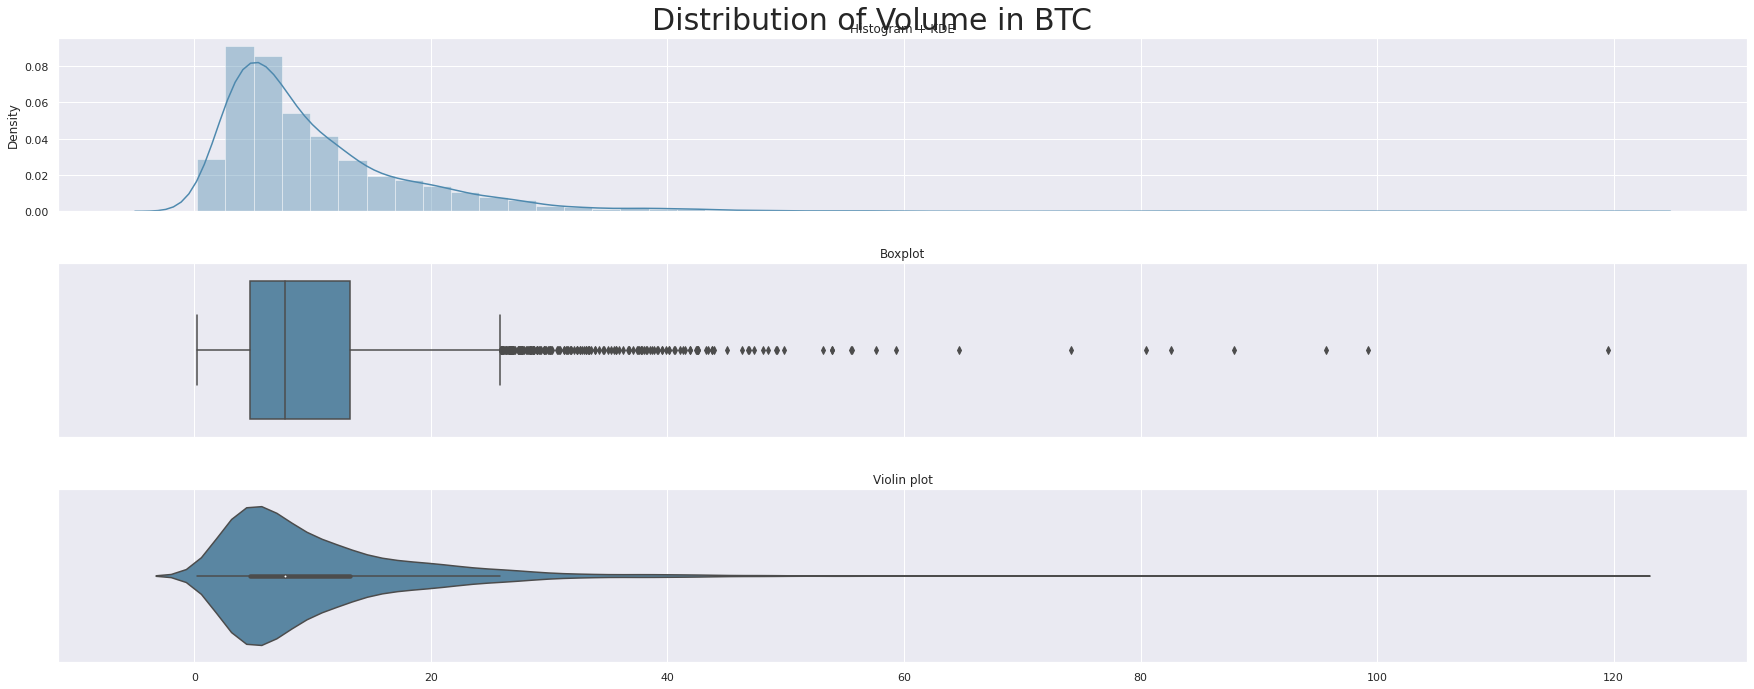

In [132]:
triple_plot(data['Volume_(BTC)'],'Distribution of Volume in BTC ',custom_colors[0])

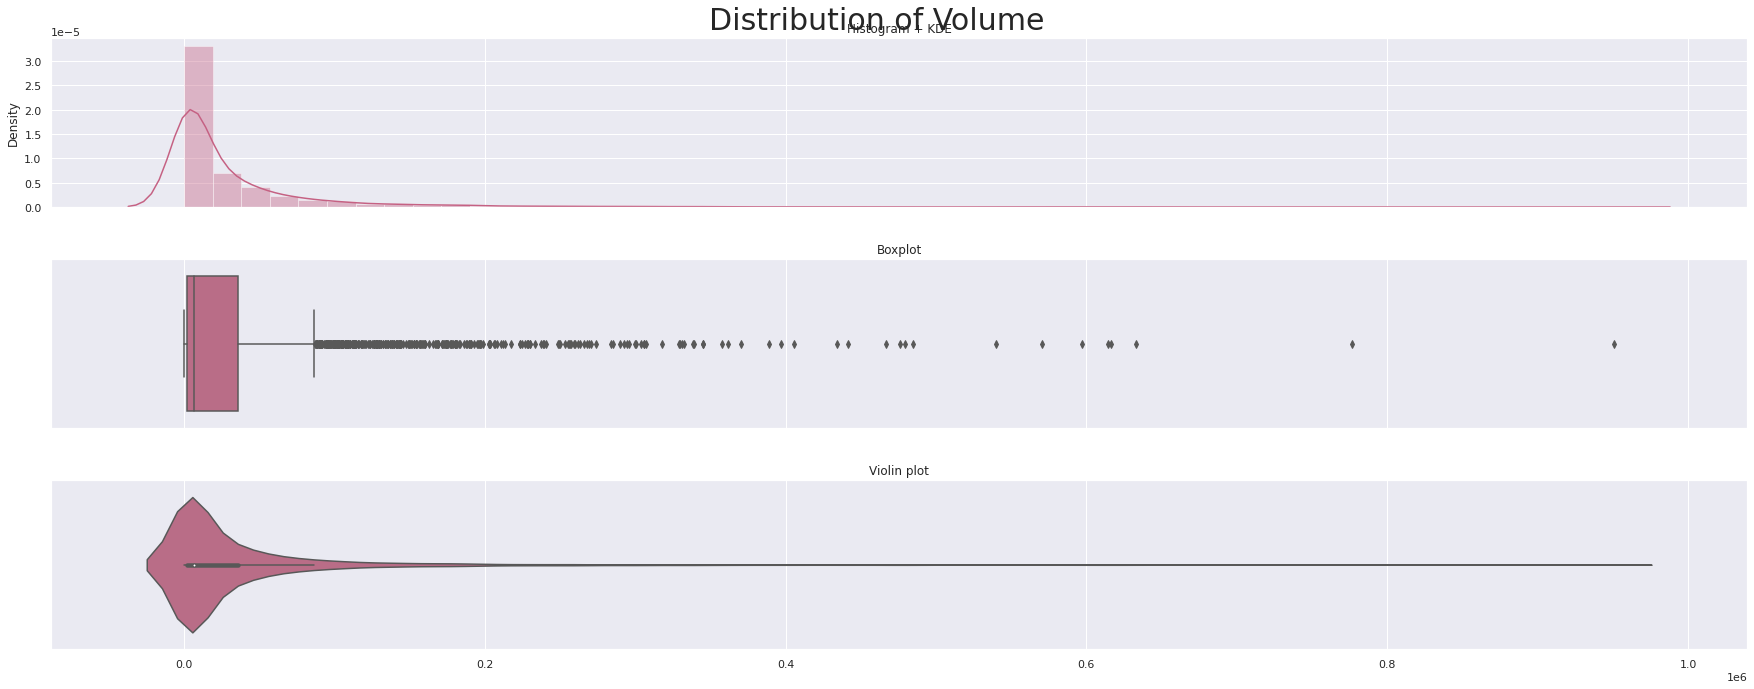

In [133]:
triple_plot(data['Volume_(Currency)'],'Distribution of Volume', custom_colors[1])

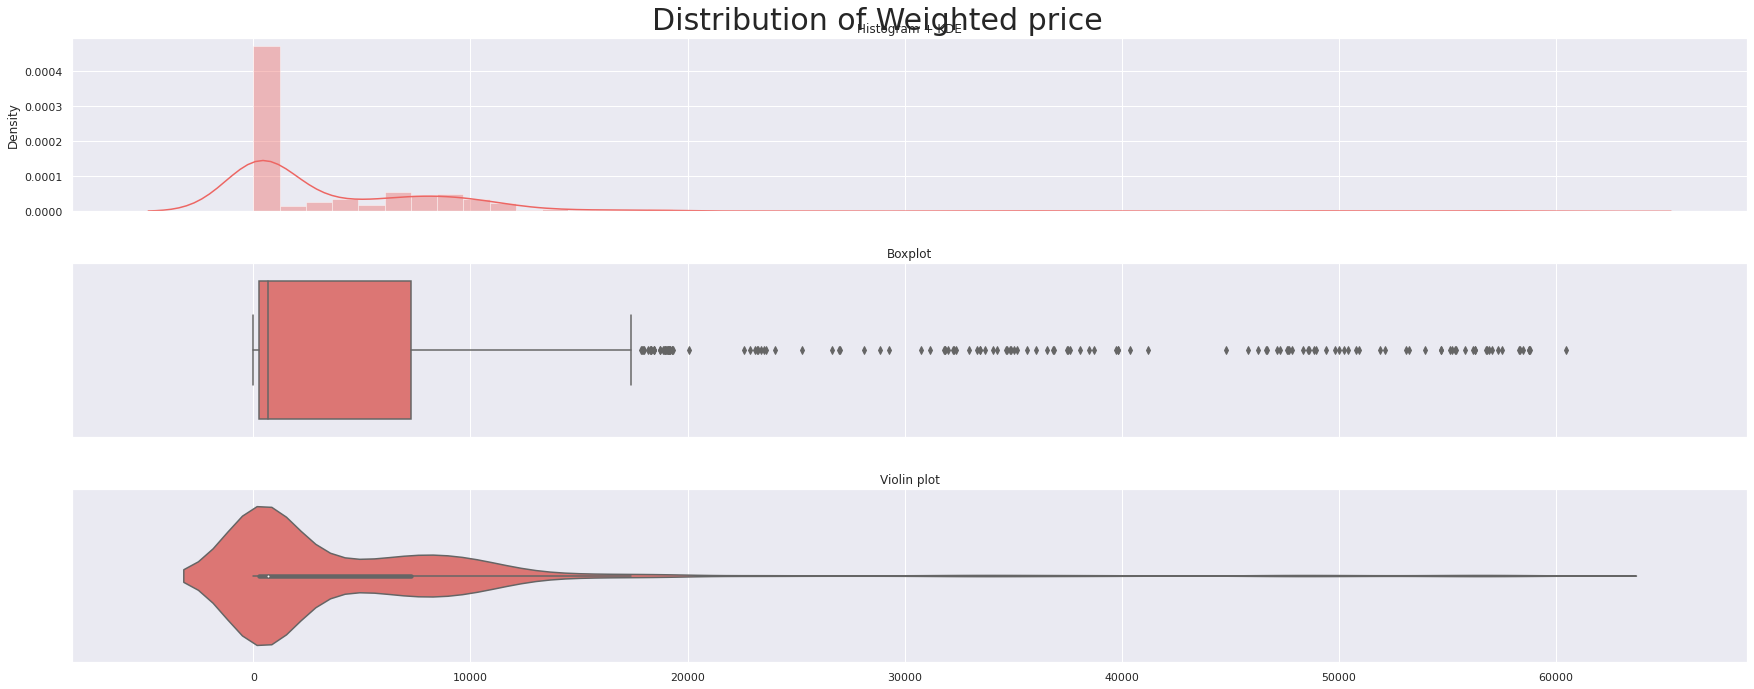

In [135]:
triple_plot(data['Weighted_Price'],'Distribution of Weighted price', custom_colors[2])

### Next, I am going to perform correlation of numeric columns

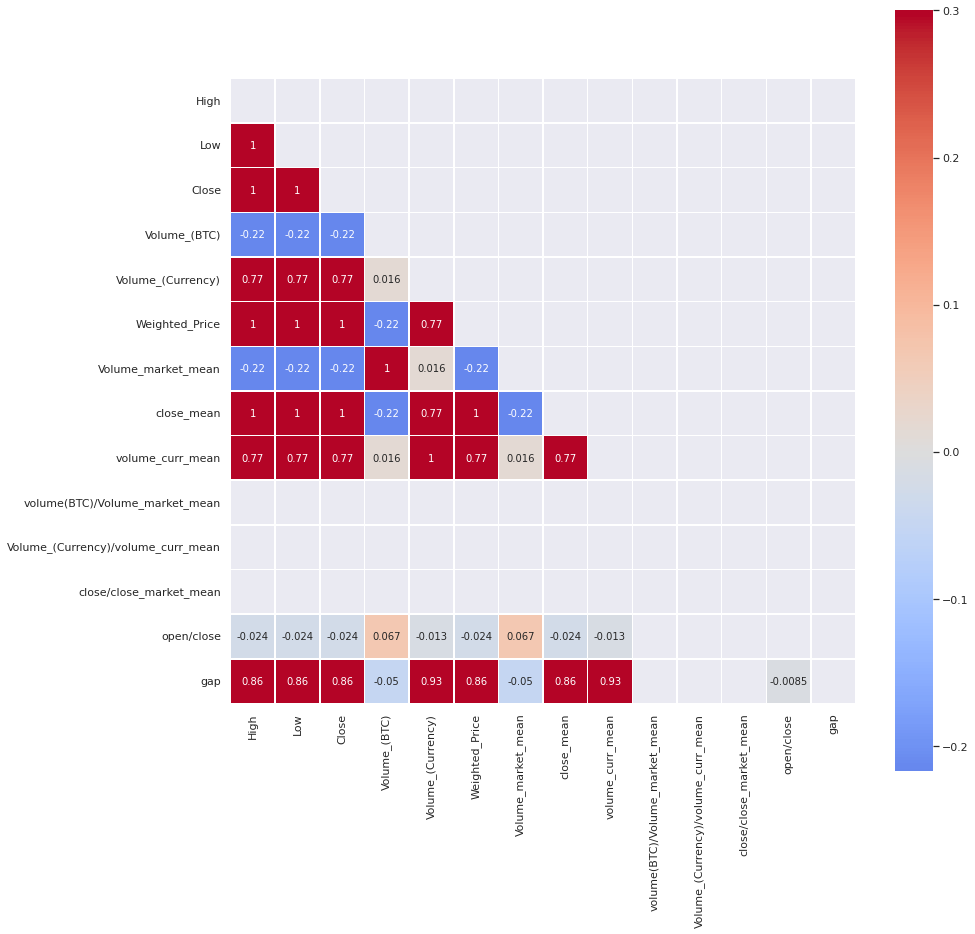

In [138]:
plt.figure(figsize=(14,14))
corr=data_df[data_df.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data_df[data_df.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

In [139]:
data_df=data_df.drop(columns=['volume(BTC)/Volume_market_mean','Volume_(Currency)/volume_curr_mean','close/close_market_mean'])
data_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Volume_market_mean', 'close_mean',
       'volume_curr_mean', 'open/close', 'gap'],
      dtype='object')

### Correlation Network next

In [141]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: indices[x])

In [142]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(9,9))

    nx.draw_networkx_nodes(H,positions,node_color='#d100d1',nodelist=nodelist,
                       node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=13)

    if corr_direction == "positive":
        edge_colour = plt.cm.summer 
    else:
        edge_colour = plt.cm.autumn
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

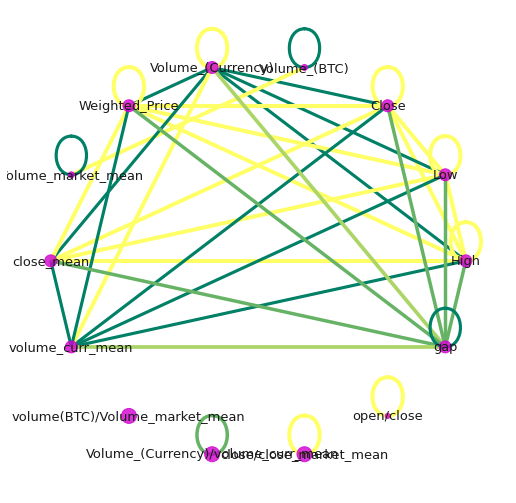

In [143]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)

In [146]:
trace1 = {
    'x': data_df.index,
    'open': data_df.Open,
    'close': data_df.Close,
    'high': data_df.High,
    'low': data_df.Low,
    'type': 'candlestick',
    'name': 'MSFT',
    'showlegend': False
}
# Calculate and define moving average of 30 periods
avg_30 = data_df.Close.rolling(window=30, min_periods=1).mean()

# Calculate and define moving average of 50 periods
avg_50 = data_df.Close.rolling(window=50, min_periods=1).mean()

trace2 = {
    'x': data_df.index,
    'y': avg_30,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'blue'
            },
    'name': 'Moving Average of 30 periods'
}

trace3 = {
    'x': data_df.index,
    'y': avg_50,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'red'
    },
    'name': 'Moving Average of 50 periods'
}
data_trace = [trace1, trace2, trace3]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Bitcoin Moving Averages',
        'font': {
            'size': 15
        } 
    }
})

fig = go.Figure(data=data_trace, layout=layout)
fig.write_html("Bitcoin Moving Averages.html")
fig.show()

In [147]:
data_df.reset_index(inplace=True)
data_df['month']=data_df['Timestamp'].dt.month
layout = go.Layout({
    'title': {
        'text': 'Bitcoin Price - Monthly',
        'font': {
            'size': 15
        } 
    }
})

fig = go.Figure(data=[go.Candlestick(x=data_df['month'],
                open=data_df['Open'], high=data_df['High'],
                low=data_df['Low'], close=data_df['Weighted_Price'])
                      ],layout=layout)
fig.show()

###Time series Analysis and Prediction using Prophet

### Prophet:
Prophet is a facebook's opensource library for time series prediction. Prophet decomposes time series into trend, seasonality and holiday. It has intuitive hyper parameters tuning which is easy to tune.

Advantages of using Prophet are the following:
1. Accommodates seasonality with multiple periods
2. Prophet is resilient to missing values
3. Best way to handle outliers in Prophet is to remove them
4. Fitting of the model is fast
5. Intuitive hyper parameters which are easy to tune

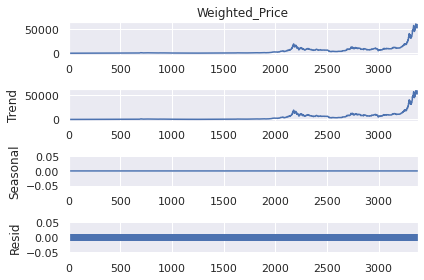

<Figure size 1080x1296 with 0 Axes>

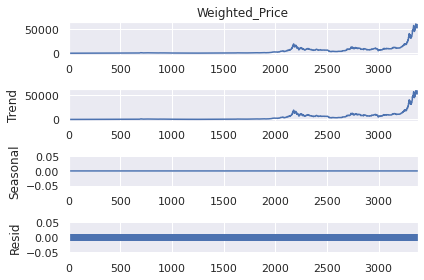

In [149]:
plt.figure(figsize=(15,18))
series = data_df.Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

Input to Prophet is a data frame with minimum two columns : ds and y

In [150]:
# Renaming the column names accroding to Prophet's requirements
prophet_df=data_df[['Timestamp','Weighted_Price']]
prophet_df.rename(columns={'Timestamp':'ds','Weighted_Price':'y'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Creating and fitting the Prophet model with default values
First, I will explore the default Prophet model. Create the Prophet instance with all default values and fit the dataset.

In [151]:
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


####Predicting the values for the future
For predicting the values using Prophet, I need to create a dataframe with ds(datetime stamp) containing the dates for which we want to make the predictions.

I will use make_future_dataframe() to which I specify the number of days to extend into the future. By default it includes dates from the history

In [ ]:
future= prophet_basic.make_future_dataframe(periods=365)#Making predictions for one year
future.tail(2)

,ds
3742,2022-03-30
3743,2022-03-31


# Let's plot the predicted data

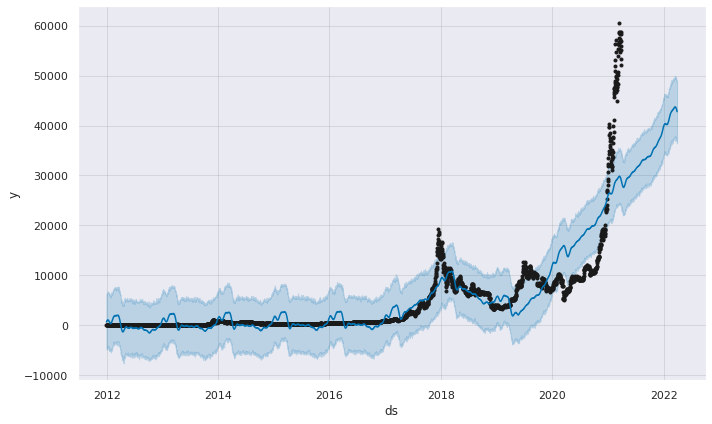

In [152]:
forecast=prophet_basic.predict(future)
fig1 =prophet_basic.plot(forecast)

###Plotting the Forecasted components(Trend and Seasonality

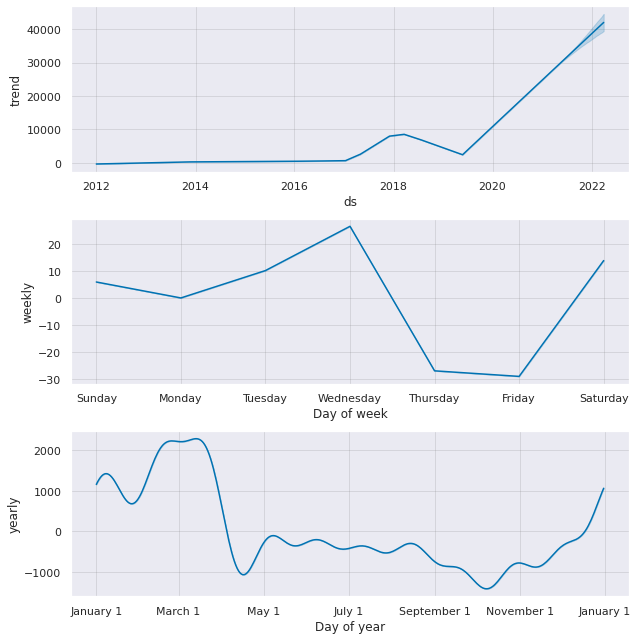

In [153]:
fig1 = prophet_basic.plot_components(forecast)

### I am goint to add change points to Prophet
Changepoints are the datetime points where the time series have abrupt changes in the trajectory.
By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

Let’s plot the vertical lines where the potential changepoints occurred

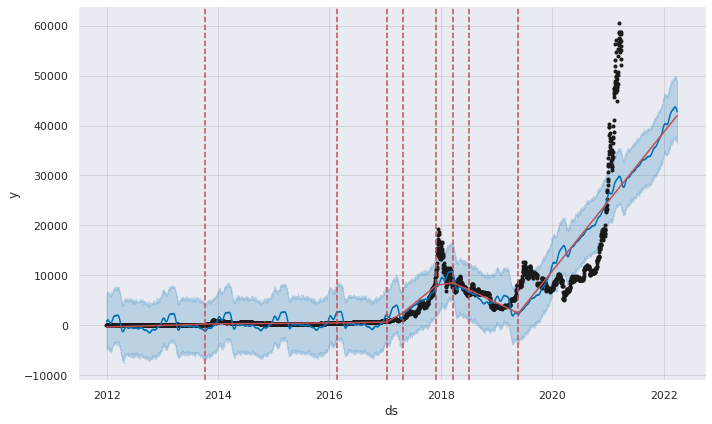

In [154]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

### Adding Multiple Regressors
Additional regressors can be added to the Prophet model. This is done by using add_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.
Creating fitting and predicting dataset with additional regressors

In [155]:
data_df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price', 'Volume_market_mean',
       'close_mean', 'volume_curr_mean', 'open/close', 'gap', 'month'],
      dtype='object')

In [156]:
prophet_df['Open'] = data_df['Open']
prophet_df['High'] = data_df['High']
prophet_df['Low'] = data_df['Low']
prophet_df['Vol(BTC)'] = data_df['Volume_(BTC)']
prophet_df['Vol(curr)'] = data_df['Volume_(Currency)']
prophet_df['Volume_market_mean'] = data_df['Volume_market_mean']
prophet_df['close_mean'] = data_df['close_mean']
prophet_df['volume_curr_mean'] = data_df['volume_curr_mean']
prophet_df['open/close'] = data_df['open/close']
prophet_df['gap'] = data_df['gap']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [157]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol(BTC)')
pro_regressor.add_regressor('Vol(curr)')
pro_regressor.add_regressor('Volume_market_mean')
pro_regressor.add_regressor('close_mean')
pro_regressor.add_regressor('volume_curr_mean')
pro_regressor.add_regressor('open/close')
pro_regressor.add_regressor('gap')

train_X= prophet_df[:2500]
test_X= prophet_df[2500:]

In [158]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


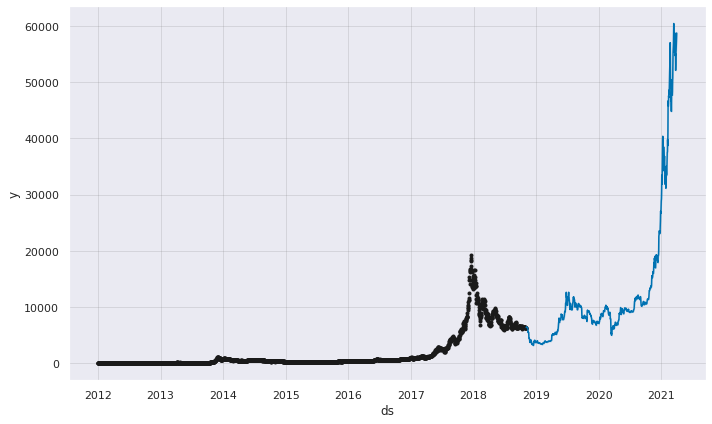

In [159]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

#### Six different types of metrics are shown by each time horizon, but by taking moving average over 37 days in this case (this can be changed by ‘rolling_window’ option).

INFO:prophet:Making 12 forecasts with cutoffs between 2012-06-02 00:00:00 and 2017-11-03 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.435364,0.659821,0.213072,0.001155,0.000104,0.001159,0.708904
1,38 days,0.492832,0.702020,0.227979,0.001259,0.000105,0.001263,0.703196
2,39 days,0.563683,0.750788,0.245117,0.001372,0.000107,0.001376,0.698630
3,40 days,0.639514,0.799696,0.263343,0.001492,0.000109,0.001496,0.694064
4,41 days,0.713277,0.844557,0.280501,0.001616,0.000111,0.001621,0.689498


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,24.531084,4.952886,1.910151,0.006234,0.000528,0.006319,0.856164
325,362 days,24.551920,4.954989,1.910892,0.006233,0.000168,0.006319,0.858447
326,363 days,24.572594,4.957075,1.911356,0.006230,0.000506,0.006316,0.860731
327,364 days,24.595099,4.959345,1.912100,0.006226,0.000516,0.006312,0.863014
328,365 days,24.619393,4.961793,1.912380,0.006219,0.000486,0.006306,0.865297


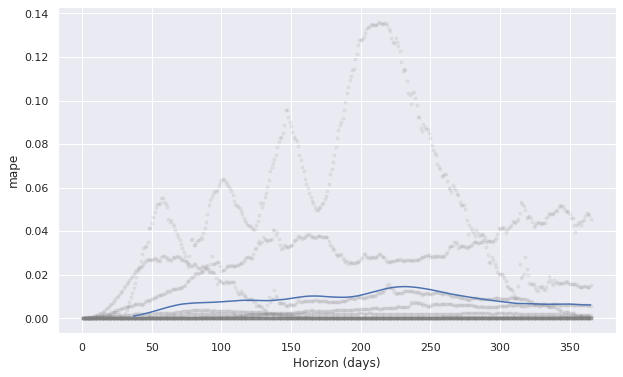

In [160]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()

###MAPE
The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error

Many organizations focus primarily on the MAPE when assessing forecast accuracy. Most people are comfortable thinking in percentage terms, making the MAPE easy to interpret. It can also convey information when you don’t know the item’s demand volume. For example, telling your manager, "we were off by less than 4%" is more meaningful than saying "we were off by 3,000 cases," if your manager doesn’t know an item’s typical demand volume.

What Prophet does not lack
1.Prophet does not allow non-Gaussian noise distribution:
In Prophet, noise distribution is always Gaussian and pre-transformation of y values is the only way to handle the values following skewed distribution.

2. Prophet does not take autocorrelation on residual into account
Since epsilon noise portion in the formula assume i.i.d. normal distribution, the residual is not assumed to have autocorrelation, unlike ARIMA model.

3. Prophet does not assume stochastic trend
Prophet’s trend component is always deterministic+possible changepoints and it won’t assume stochastic trend unlike ARIMA.

## Prediction using Pycaret

In [161]:
!pip install pycaret==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 4.7 MB/s 
     |████████████████████████████████| 14.8 MB 98.1 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 25.9 MB 11.3 MB/s 
     |████████████████████████████████| 268 kB 95.4 MB/s 
     |████████████████████████████████| 6.8 MB 80.6 MB/s 
     |████████████████████████████████| 17.0 MB 77.5 MB/s 
     |████████████████████████████████| 10.4 MB 89.5 MB/s 
     |████████████████████████████████| 88 kB 8.5 MB/s 
     |████████████████████████████████| 134 kB 83.6 MB/s 
     |████████████████████████████████| 1.7 MB 78.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 68.8 MB/s 
     |███████████████████████████████

### PyCaret Regression Module:

PyCaret Regression Module is a supervised machine learning module that is used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, ‘predictors’, or ‘covariates’).

The objective of regression is to predict continuous values such as predicting sales amount, predicting quantity, predicting temperature, etc. This module provides several pre-processing features that prepare the data for modeling through the setup function. It has over 25 ready-to-use algorithms and several plots to analyze the performance of trained models.

In [162]:
data_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume_market_mean,close_mean,volume_curr_mean,open/close,gap,month
0,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,23.829470,4.482500,106.330084,0.996096,0.017500,12
1,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,7.200667,4.806667,35.259720,1.000000,0.000000,1
2,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,19.048000,5.000000,95.240000,1.000000,0.000000,1
3,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,11.004660,5.252500,58.100651,1.000000,0.000000,1
4,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,11.914807,5.223333,63.119577,0.995533,0.023333,1


In [163]:
%%time
from pycaret.regression import *
data_df.set_index('Timestamp',inplace=True)
exp_name = setup(data=data_df,target="Weighted_Price",silent=True)
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,583.1456,1.955018e+06,1335.1584,0.9648,0.7660,1.5891,0.042
lightgbm,Light Gradient Boosting Machine,412.4802,2.137356e+06,1363.4077,0.9639,0.5717,0.8504,0.051
rf,Random Forest Regressor,398.4551,2.055025e+06,1312.8139,0.9632,0.2023,0.2564,0.132
et,Extra Trees Regressor,376.2235,2.117648e+06,1277.3412,0.9625,0.1564,0.0999,0.111
dt,Decision Tree Regressor,562.6792,4.164410e+06,1896.2207,0.9276,0.2230,0.1531,0.010
ada,AdaBoost Regressor,2153.8588,7.979445e+06,2765.0446,0.8590,2.3478,39.9922,0.028
llar,Lasso Least Angle Regression,2134.3182,1.352944e+07,3601.2872,0.7658,2.0301,24.5700,0.010
br,Bayesian Ridge,2152.7349,1.351052e+07,3600.5908,0.7657,2.0396,24.8197,0.009
lr,Linear Regression,2164.7389,1.351195e+07,3601.1815,0.7656,2.0478,25.1670,0.237
ridge,Ridge Regression,2164.2897,1.351145e+07,3601.0988,0.7656,2.0475,25.1549,0.147


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=6291, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


CPU times: user 7.95 s, sys: 1.55 s, total: 9.5 s
Wall time: 18.8 s


## References
1. Time series prediction using Prophet in Python by Renu Khandelwal
2. Housing pices EDA and Prediction by Ruchi Bhatia
88.9 r2_score with pycaret by Kerem Yucedag
3. Pycaret documentation